# 🧠 Engineering a Custom Architecture: GeM Pooling + Bottleneck Head

We are moving beyond "lazy" transfer learning. Instead of using the default classifier, we are extracting raw feature maps from the backbone and processing them through custom engineering.

## Architectural Improvements:
1.  **GeM (Generalized Mean Pooling)**: A learnable pooling layer. The parameter `p` is trained via backprop, allowing the model to interpret histology features as either "texture" (AvgPool) or "salient objects" (MaxPool) automatically.
2.  **Mish Activation**: A self-regularized non-monotonic activation function ($x \cdot \tanh(\ln(1+e^x))$) that generally outperforms ReLU in deep networks.
3.  **Bottleneck Head**: We project high-dimensional features down to a lower dimension with Batch Normalization and Dropout before the final classification, stabilizing the manifold.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import timm
from PIL import Image
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# --- SETUP ---
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_ROOT = os.path.join(os.path.pardir, "an2dl2526c2")
LABELS_CSV = os.path.join(DATASET_ROOT, "train_labels.csv")
CLEAN_DATA_DIR = os.path.join(DATASET_ROOT, "train_masked_noshreks")
TEST_DATA_DIR = os.path.join(DATASET_ROOT, "test_masked_noshreks")
MODEL_DIR = "models"

if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(SEED)

# --- DATA LOADING (Same as fixed version) ---
labels_df = pd.read_csv(LABELS_CSV)
labels_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1]))
valid_filenames = sorted([f for f in os.listdir(CLEAN_DATA_DIR) if f in labels_map])
y_labels_raw = [labels_map[f] for f in valid_filenames]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels_raw)
CLASSES = label_encoder.classes_
NUM_CLASSES = len(CLASSES)

# Use pre-calculated stats for stability in this snippet
DATASET_MEAN = [0.485, 0.456, 0.406] # Placeholder: Replace with your calc if you ran the prev notebook
DATASET_STD = [0.229, 0.224, 0.225]

class HistologyDataset(Dataset):
    def __init__(self, filenames, labels, root_dir, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self): return len(self.filenames)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_dir, self.filenames[idx])).convert("RGB")
        if self.transform: img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

X_train, X_temp, y_train, y_temp = train_test_split(valid_filenames, y_encoded, test_size=0.2, stratify=y_encoded, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

class_counts = Counter(y_train)
sample_weights = [1.0/class_counts[label] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATASET_MEAN, std=DATASET_STD)
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATASET_MEAN, std=DATASET_STD)
])

train_loader = DataLoader(HistologyDataset(X_train, y_train, CLEAN_DATA_DIR, train_transform), batch_size=16, sampler=sampler, num_workers=0, drop_last=True)
val_loader = DataLoader(HistologyDataset(X_val, y_val, CLEAN_DATA_DIR, val_transform), batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(HistologyDataset(X_test, y_test, CLEAN_DATA_DIR, val_transform), batch_size=16, shuffle=False, num_workers=0)

## 2. Advanced Component Definitions
Here we define the custom layers: `GeM` pooling and the `AdvancedConvNeXt` model.

In [2]:
# --- 1. Generalized Mean Pooling (GeM) ---
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        # p is a learnable parameter initialized to 3
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        # x shape: (Batch, Channels, Height, Width)
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        # Average Pooling formula: Mean(X)
        # GeM formula: (Mean(X^p))^(1/p)
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

# --- 2. The Custom Architecture ---
class AdvancedConvNeXt(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AdvancedConvNeXt, self).__init__()
        
        # 1. Backbone: ConvNeXt-Tiny
        # num_classes=0 removes the head. global_pool='' keeps the 4D feature map (B, C, H, W)
        self.backbone = timm.create_model('convnext_tiny', pretrained=pretrained, num_classes=0, global_pool='')
        
        # Get feature dimension (768 for convnext_tiny)
        in_features = self.backbone.num_features
        
        # 2. Aggregator: GeM Pooling
        self.pool = GeM()
        
        # 3. Head: Bottleneck Architecture
        self.head = nn.Sequential(
            nn.Linear(in_features, 512),       # Project down
            nn.BatchNorm1d(512),               # Normalize
            nn.Mish(inplace=True),             # Advanced Activation
            nn.Dropout(0.5),                   # Regularize
            nn.Linear(512, num_classes)        # Classify
        )

    def forward(self, x):
        # Extract features -> (Batch, Channels, H, W)
        features = self.backbone(x)
        
        # Aggregate features -> (Batch, Channels, 1, 1)
        pooled = self.pool(features)
        
        # Flatten -> (Batch, Channels)
        pooled_flat = torch.flatten(pooled, 1)
        
        # Classify
        return self.head(pooled_flat)

model = AdvancedConvNeXt(num_classes=NUM_CLASSES).to(DEVICE)
print(model)

AdvancedConvNeXt(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw

## 3. Training Loop with Layer-Wise Learning Rates
Since we engineered a custom head, we should train the head faster than the backbone. We use parameter groups to assign different learning rates.

In [5]:
def get_optimizer(model, learning_rate=1e-4):
    # Split params into backbone (slow learning) and head (fast learning)
    backbone_params = list(map(id, model.backbone.parameters()))
    head_params = filter(lambda p: id(p) not in backbone_params, model.parameters())
    
    params = [
        {'params': model.backbone.parameters(), 'lr': learning_rate * 0.1}, # 10x slower for backbone
        {'params': head_params, 'lr': learning_rate}  # Full speed for head/GeM
    ]
    return optim.AdamW(params, weight_decay=1e-2)

# Standard Train/Val Functions
def train_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE).long()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / total, correct / total

# --- CONFIG ---
EPOCHS = 60
LR = 1e-4 # Higher initial LR because we scale down backbone LR
PATIENCE = 15
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_advanced_model.pth")

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = get_optimizer(model, LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
scaler = torch.cuda.amp.GradScaler()

print("Starting Advanced Training...")
best_val_acc = 0.0
patience_counter = 0

for epoch in range(EPOCHS):
    t_loss, t_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)
    v_loss, v_acc = validate(model, val_loader, criterion)
    
    # Print the learnable p value to see it adapting
    current_p = model.pool.p.item()
    print(f"Epoch {epoch+1} | Train L:{t_loss:.4f} A:{t_acc:.4f} | Val L:{v_loss:.4f} F1:{v_acc:.4f} | GeM p: {current_p:.4f}")
    
    scheduler.step(v_loss)
    
    if v_acc > best_val_acc:
        best_val_acc = v_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= PATIENCE:
        print("Early Stopping.")
        break

C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_20244\3449287978.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Advanced Training...


Training:   0%|          | 0/63 [00:00<?, ?it/s]C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_20244\3449287978.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train L:1.3983 A:0.2887 | Val L:1.4122 F1:0.2063 | GeM p: 3.0052


Epoch 2 | Train L:1.4033 A:0.3065 | Val L:1.4434 F1:0.2937 | GeM p: 3.0057


Epoch 3 | Train L:1.3835 A:0.3125 | Val L:1.4230 F1:0.3571 | GeM p: 3.0063


Epoch 4 | Train L:1.3698 A:0.3403 | Val L:1.4098 F1:0.2937 | GeM p: 3.0064


Epoch 5 | Train L:1.3444 A:0.3651 | Val L:1.4690 F1:0.2778 | GeM p: 3.0066


Epoch 6 | Train L:1.3226 A:0.3849 | Val L:1.3998 F1:0.3730 | GeM p: 3.0072


Epoch 7 | Train L:1.2782 A:0.4147 | Val L:1.6605 F1:0.1667 | GeM p: 3.0076


Epoch 8 | Train L:1.2132 A:0.4663 | Val L:1.5512 F1:0.2857 | GeM p: 3.0087


Epoch 9 | Train L:1.1790 A:0.5129 | Val L:1.5475 F1:0.2540 | GeM p: 3.0097


Epoch 10 | Train L:1.1666 A:0.5060 | Val L:1.5138 F1:0.3492 | GeM p: 3.0117


Epoch 11 | Train L:1.1134 A:0.5446 | Val L:1.5982 F1:0.2857 | GeM p: 3.0143


Epoch 12 | Train L:1.0558 A:0.6161 | Val L:1.4135 F1:0.3810 | GeM p: 3.0150


Epoch 13 | Train L:0.9770 A:0.6617 | Val L:1.4404 F1:0.3413 | GeM p: 3.0156


Epoch 14 | Train L:0.9613 A:0.6637 | Val L:1.5172 F1:0.3254 | GeM p: 3.0162


Epoch 15 | Train L:0.9619 A:0.6806 | Val L:1.5037 F1:0.3413 | GeM p: 3.0168


Epoch 16 | Train L:0.8829 A:0.7202 | Val L:1.4608 F1:0.3730 | GeM p: 3.0174


Epoch 17 | Train L:0.8715 A:0.7192 | Val L:1.4911 F1:0.3333 | GeM p: 3.0177


Epoch 18 | Train L:0.8605 A:0.7312 | Val L:1.4156 F1:0.3889 | GeM p: 3.0180


Epoch 19 | Train L:0.8708 A:0.7321 | Val L:1.4035 F1:0.3968 | GeM p: 3.0182


Epoch 20 | Train L:0.8180 A:0.7698 | Val L:1.4589 F1:0.3651 | GeM p: 3.0182


Epoch 21 | Train L:0.8277 A:0.7589 | Val L:1.4647 F1:0.3730 | GeM p: 3.0186


Epoch 22 | Train L:0.7788 A:0.7857 | Val L:1.4799 F1:0.3968 | GeM p: 3.0188


Epoch 23 | Train L:0.7944 A:0.7758 | Val L:1.4716 F1:0.3968 | GeM p: 3.0189


Epoch 24 | Train L:0.7877 A:0.7718 | Val L:1.4797 F1:0.3968 | GeM p: 3.0189


Epoch 25 | Train L:0.7694 A:0.7907 | Val L:1.4477 F1:0.3968 | GeM p: 3.0190


Epoch 26 | Train L:0.7538 A:0.8026 | Val L:1.4623 F1:0.3889 | GeM p: 3.0190


Epoch 27 | Train L:0.7822 A:0.7986 | Val L:1.4777 F1:0.3810 | GeM p: 3.0192


Epoch 28 | Train L:0.7571 A:0.7986 | Val L:1.4997 F1:0.3571 | GeM p: 3.0192


Epoch 29 | Train L:0.7665 A:0.7827 | Val L:1.4728 F1:0.3968 | GeM p: 3.0193


Epoch 30 | Train L:0.7493 A:0.8185 | Val L:1.4752 F1:0.3889 | GeM p: 3.0194


Epoch 31 | Train L:0.7495 A:0.8155 | Val L:1.4828 F1:0.4206 | GeM p: 3.0195


Epoch 32 | Train L:0.7358 A:0.8155 | Val L:1.4804 F1:0.3968 | GeM p: 3.0195


Epoch 33 | Train L:0.7543 A:0.7996 | Val L:1.4984 F1:0.3968 | GeM p: 3.0196


Epoch 34 | Train L:0.7805 A:0.7837 | Val L:1.4854 F1:0.3968 | GeM p: 3.0196


Epoch 35 | Train L:0.7490 A:0.8115 | Val L:1.4788 F1:0.4048 | GeM p: 3.0196


Epoch 36 | Train L:0.7299 A:0.8145 | Val L:1.4672 F1:0.3889 | GeM p: 3.0197


Epoch 37 | Train L:0.7331 A:0.8065 | Val L:1.4894 F1:0.3889 | GeM p: 3.0197


Epoch 38 | Train L:0.7292 A:0.8155 | Val L:1.4816 F1:0.3968 | GeM p: 3.0197


Epoch 39 | Train L:0.7348 A:0.8224 | Val L:1.4844 F1:0.4127 | GeM p: 3.0197


Epoch 40 | Train L:0.7451 A:0.8006 | Val L:1.4993 F1:0.3968 | GeM p: 3.0197


Epoch 41 | Train L:0.7379 A:0.8185 | Val L:1.4678 F1:0.3889 | GeM p: 3.0198


Epoch 42 | Train L:0.6975 A:0.8403 | Val L:1.4787 F1:0.3968 | GeM p: 3.0198


Epoch 43 | Train L:0.7271 A:0.8085 | Val L:1.4764 F1:0.3810 | GeM p: 3.0198


Epoch 44 | Train L:0.7343 A:0.8155 | Val L:1.4925 F1:0.3889 | GeM p: 3.0198


Epoch 45 | Train L:0.7398 A:0.8115 | Val L:1.5012 F1:0.3810 | GeM p: 3.0198


Epoch 46 | Train L:0.7140 A:0.8472 | Val L:1.4925 F1:0.3968 | GeM p: 3.0198
Early Stopping.


In [7]:
print("Loading best model for internal testing...")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Standard Inference
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n--- Internal Test Set Results ---")
print(classification_report(all_labels, all_preds, target_names=CLASSES, digits=4))

C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_20244\3198198808.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH))


Loading best model for internal testing...


Testing: 100%|██████████| 8/8 [00:00<00:00, 10.26it/s]


--- Internal Test Set Results ---
                 precision    recall  f1-score   support

        HER2(+)     0.4000    0.2424    0.3019        33
      Luminal A     0.3182    0.4118    0.3590        34
      Luminal B     0.3810    0.3556    0.3678        45
Triple negative     0.1905    0.2667    0.2222        15

       accuracy                         0.3307       127
      macro avg     0.3224    0.3191    0.3127       127
   weighted avg     0.3466    0.3307    0.3311       127



## 4. Inference (TTA)
Standard TTA loop as implemented previously.

In [6]:
class SubmissionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.filenames = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg'))])
        self.transform = transform
    def __len__(self): return len(self.filenames)
    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img = Image.open(os.path.join(self.root_dir, fname)).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, fname

if os.path.exists(TEST_DATA_DIR):
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model.eval()
    sub_loader = DataLoader(SubmissionDataset(TEST_DATA_DIR, val_transform), batch_size=16, shuffle=False)
    
    all_preds = []
    all_files = []
    
    with torch.no_grad():
        for images, filenames in tqdm(sub_loader, desc="Inference"):
            images = images.to(DEVICE)
            # TTA: Avg(Original, HFlip, VFlip)
            p1 = torch.softmax(model(images), 1)
            p2 = torch.softmax(model(torch.flip(images, [3])), 1)
            p3 = torch.softmax(model(torch.flip(images, [2])), 1)
            avg = (p1+p2+p3)/3
            _, preds = torch.max(avg, 1)
            all_preds.extend(preds.cpu().numpy())
            all_files.extend(filenames)
            
    pred_labels = label_encoder.inverse_transform(all_preds)
    df = pd.DataFrame({'sample_index': all_files, 'label': pred_labels})
    df.to_csv("submission_advanced.csv", index=False)
    print("Done.")

C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_20244\959820463.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH))
Infe

Done.


Scanning for traitors...


Scanning: 100%|██████████| 64/64 [00:05<00:00, 12.54it/s]


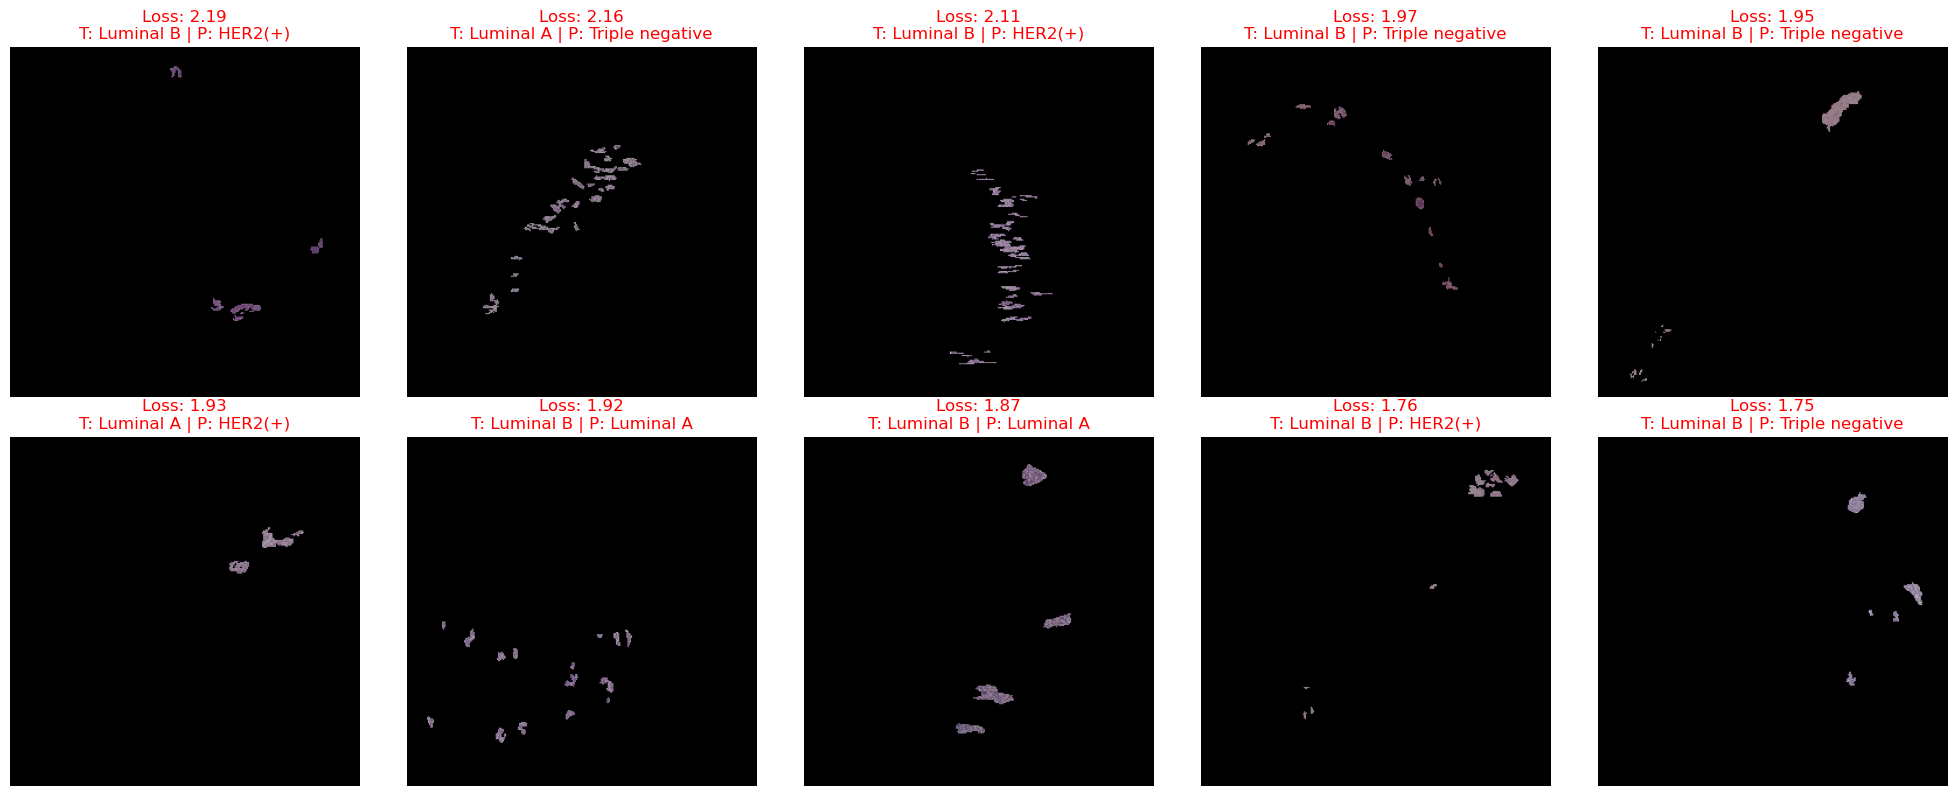

In [11]:
import matplotlib.pyplot as plt
# --- 9. INSPECT OUTLIERS ("TRAITORS") ---
# Advice: "Plot the highest losses. Look at them."

def find_outliers(model, dataset, top_k=10):
    # Create a loader with shuffle=False to track filenames
    # Note: dataset here should be the training dataset or a subset of it
    temp_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)
    model.eval()
    
    criterion_none = nn.CrossEntropyLoss(reduction='none')
    results = []
    
    print("Scanning for traitors...")
    with torch.no_grad():
        batch_start_idx = 0
        for images, labels in tqdm(temp_loader, desc="Scanning"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).long()
            
            outputs = model(images)
            losses = criterion_none(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            losses = losses.cpu().numpy()
            preds = preds.cpu().numpy()
            
            for i in range(len(images)):
                if batch_start_idx + i < len(dataset):
                    dataset_idx = batch_start_idx + i
                    # Access underlying dataset if using Subset
                    if hasattr(dataset, 'dataset'):
                        filename = dataset.dataset.filenames[dataset.indices[dataset_idx]]
                        true_label_idx = dataset.dataset.labels[dataset.indices[dataset_idx]]
                    else:
                        filename = dataset.filenames[dataset_idx]
                        true_label_idx = dataset.labels[dataset_idx]
                        
                    results.append({
                        'filename': filename,
                        'loss': losses[i],
                        'true': CLASSES[true_label_idx] if isinstance(true_label_idx, int) else CLASSES[true_label_idx.item()],
                        'pred': CLASSES[preds[i]]
                    })
            batch_start_idx += len(images)
            
    # Sort by loss descending
    results.sort(key=lambda x: x['loss'], reverse=True)
    return results[:top_k]

# Create a fresh dataset instance for inspection to ensure order and no transforms that hide the image
# We'll use the 'train' subset logic if possible, or just re-use the train_loader's dataset
try:
    # Assuming X_train, y_train are available from previous cells
    inspection_dataset = HistologyDataset(X_train, y_train, CLEAN_DATA_DIR, val_transform)
    top_outliers = find_outliers(model, inspection_dataset, top_k=10)

    # Visualize
    plt.figure(figsize=(20, 8))
    for i, item in enumerate(top_outliers):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(CLEAN_DATA_DIR, item['filename'])
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Loss: {item['loss']:.2f}\nT: {item['true']} | P: {item['pred']}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not run inspection: {e}")